## Import libraries

In [ ]:
from google.colab import drive
from urllib import request

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from urllib import request
import logging
from pathlib import Path
import random
import re

from gensim import corpora, models

In [ ]:
try:
    if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
        print("tqdm is notebook version")
        from tqdm import tqdm_notebook as tqdm
    else:
        raise RuntimeError
except (NameError, RuntimeError):
    from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pickle

In [ ]:
df_s_sample = pd.read_csv(r"/content/drive/My Drive/LDA_project/df_s_sample.csv")
df_s_sample.head()

In [ ]:
df_s_sample.groupby('source').count()

id  title   date   body  label
source                                         
nytimes.com    2998   2998   2998   2998   2976
reuters.com   13164  13164  13164  13164  13113
usatoday.com   5181   5181   5181   5181   5156

In [ ]:
df_s_sample.shape

(21343, 7)

## Class Tokenizer

In [ ]:
class Tokenizer:
    def __init__(self, stopwords, exclude_reg=None):
        self.stopwords = stopwords
        self.exclude_reg = exclude_reg if exclude_reg else r"$^"
        
    def tokenize(self, text):
        text = text.lower()
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        l = WordNetLemmatizer()
        res = [l.lemmatize(i) for i in tokens
                   if i not in self.stopwords]
        return res

In [ ]:
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt")
stopwords = [line.decode("utf-8").strip() for line in res]

In [ ]:
tokenizer = Tokenizer(stopwords)

In [ ]:
text = "Mike works at Apple Inc, whose main products are smartphone, tablet and personal computer"
tokenizer.tokenize(text)

['mike',
 'work',
 'apple',
 'main',
 'product',
 'smartphone',
 'tablet',
 'personal',
 'computer']

In [ ]:
df_s_sample = df_s_sample.sort_values('date')

In [ ]:
# df_s_sample.reset_index(inplace=True)
df_s_sample.drop(columns='level_0', inplace=True)
df_s_sample.head()

id  ...                 label
0  3004132926  ...                Stocks
1  3004132935  ...         Home & Garden
2  3004133406  ...  Trucks & Accessories
3  3004133425  ...         Senior Living
4  3004133785  ...           Real Estate

[5 rows x 6 columns]

# Tokenize document

In [ ]:
docs = []
for article in df_s_sample.body:
    w = tokenizer.tokenize(article)
    docs.append(w)

In [ ]:
with open('/content/drive/My Drive/LDA_project/dictionary.pkl', 'rb') as f:
  d = pickle.load(f)

In [ ]:
with open('/content/drive/My Drive/LDA_project/docs.pkl', 'rb') as f:
  docs = pickle.load(f)

In [ ]:
with open('/content/drive/My Drive/LDA_project/corpus.pkl', 'rb') as f:
  corpus = pickle.load(f)

In [ ]:
with open('/content/drive/My Drive/LDA_project/docs.pkl', 'wb') as f:
  pickle.dump(docs, f)

# Create dictionary

In [ ]:
d = corpora.Dictionary(docs)

adding document #0 to Dictionary(0 unique tokens: [])
adding document #10000 to Dictionary(71677 unique tokens: ['1', '12', '15', '20', '2017']...)
adding document #20000 to Dictionary(95127 unique tokens: ['1', '12', '15', '20', '2017']...)
built Dictionary(97646 unique tokens: ['1', '12', '15', '20', '2017']...) from 21343 documents (total 6201060 corpus positions)


In [ ]:
len(d)

97646

In [ ]:
d.filter_extremes(no_below=5, no_above=0.5)
d.compactify()
len(d)

discarding 63244 tokens: [('eurocentric', 1), ('immigrating', 3), ('kannan', 2), ('levittown', 1), ('macroaggressions', 1), ('pennsbury', 1), ('solebury', 1), ('vogelsang', 1), ('year', 12722), ('brights', 2)]...
keeping 34402 tokens which were in no less than 5 and no more than 10671 (=50.0%) documents
resulting dictionary: Dictionary(34402 unique tokens: ['1', '12', '15', '20', '2017']...)


34402

# Create corpus

In [ ]:
corpus = [d.doc2bow(w) for w in docs]

In [ ]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Train test split

In [ ]:
train_size = int(len(corpus) * 0.9)
test_corpus = corpus[train_size:]
train_corpus= corpus[:train_size]
print("text size: ", len(test_corpus))
print("train size: ", len(train_corpus))

text size:  2135
train size:  19208


# Training and tuning num of topics

In [ ]:
#Metrics for Topic Models
numoftopic_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# numoftopic_list = [30]
coherence_vals = []
perplexity_vals = []

for n_topic in numoftopic_list:
    lda = models.ldamodel.LdaModel(corpus=train_corpus, id2word=d, num_topics=n_topic, passes=10, random_state=42)
    perplexity_vals.append(np.exp2(-lda.log_perplexity(train_corpus)))
    coherence_lda = models.CoherenceModel(model=lda, texts=docs, dictionary=d, coherence='c_v')
    coherence_vals.append(coherence_lda.get_coherence())

Streaming output truncated to the last 5000 lines.
topic #16 (0.017): 0.028*"sale" + 0.026*"store" + 0.015*"price" + 0.014*"product" + 0.011*"brand" + 0.010*"retailer" + 0.010*"amazon" + 0.010*"time" + 0.009*"shopping" + 0.008*"99"
topic #38 (0.017): 0.022*"million" + 0.020*"business" + 0.018*"money" + 0.017*"job" + 0.015*"tax" + 0.014*"pay" + 0.013*"program" + 0.012*"payment" + 0.012*"000" + 0.012*"loan"
topic #54 (0.017): 0.019*"people" + 0.016*"dr" + 0.016*"patient" + 0.013*"study" + 0.011*"virus" + 0.010*"symptom" + 0.010*"hospital" + 0.009*"risk" + 0.008*"disease" + 0.008*"health"
topic diff=0.032060, rho=0.225854
PROGRESS: pass 9, at document #18000/19208
merging changes from 2000 documents into a model of 19208 documents
topic #37 (0.017): 0.023*"gas" + 0.021*"energy" + 0.017*"project" + 0.011*"company" + 0.010*"climate" + 0.010*"industry" + 0.010*"copper" + 0.010*"power" + 0.009*"oil" + 0.009*"emission"
topic #12 (0.017): 0.046*"south" + 0.046*"africa" + 0.028*"food" + 0.023*"a

In [ ]:
perplexity_vals

[317.84795205167325,
 296.97301120353086,
 280.26099010430323,
 273.78110744696477,
 272.1203738159631,
 269.8370253839799,
 267.7021621613828,
 268.9937820378686,
 526.0763843749102,
 752.2639512502735,
 841.5889816076585]

In [ ]:
coherence_vals

[0.5237270985180736,
 0.6031718904140547,
 0.6178336760632711,
 0.5829557215078912,
 0.5686876997545195,
 0.5812484232165571,
 0.5796009210167462,
 0.5536128069566499,
 0.5753501427677792,
 0.5595212751968142,
 0.5508421210056168]

In [ ]:
%ls '/content/drive/My Drive/LDA_project/

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
with open('/content/drive/My Drive/LDA_project/fix_num_topic.pkl','rb') as f:
  results = pickle.load(f)

In [ ]:
perplexity_vals = results['perplexity_vals'] 
coherence_vals = results['coherence_vals']
x = results['numoftopic_list']

# Plot result

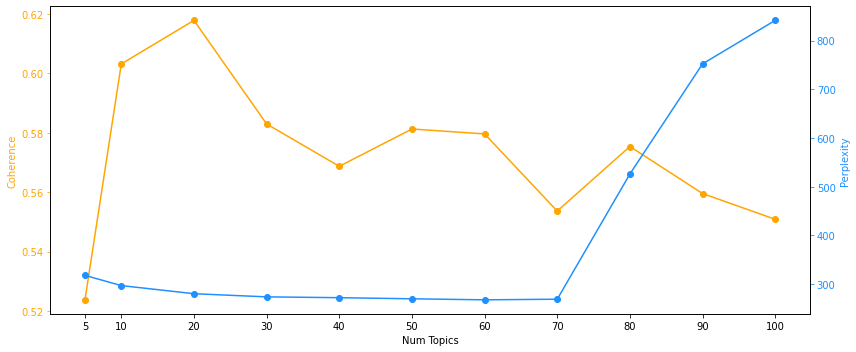

<Figure size 432x288 with 0 Axes>

In [ ]:
# evaluation
x = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'orange'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'dodgerblue'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

plt.savefig('/content/drive/My Drive/LDA_project/numOfTopic.png') 

# Final model

In [ ]:
result = dict()
result['perplexity_vals'] = perplexity_vals
result['coherence_vals'] = coherence_vals
result['numoftopic_list'] = numoftopic_list

In [ ]:
result

{'coherence_vals': [0.5237270985180736,
  0.6031718904140547,
  0.6178336760632711,
  0.5829557215078912,
  0.5686876997545195,
  0.5812484232165571,
  0.5796009210167462,
  0.5536128069566499,
  0.5753501427677792,
  0.5595212751968142,
  0.5508421210056168],
 'numoftopic_list': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'perplexity_vals': [317.84795205167325,
  296.97301120353086,
  280.26099010430323,
  273.78110744696477,
  272.1203738159631,
  269.8370253839799,
  267.7021621613828,
  268.9937820378686,
  526.0763843749102,
  752.2639512502735,
  841.5889816076585]}

In [ ]:
with open('/content/drive/My Drive/LDA_project/fix_num_topic.pkl', 'wb') as f:
  pickle.dump(result, f)

In [ ]:
with open('/content/drive/My Drive/LDA_project/corpus.pkl', 'wb') as f:
  pickle.dump(corpus, f)

In [ ]:
with open('/content/drive/My Drive/LDA_project/dictionary.pkl', 'wb') as f:
  pickle.dump(d, f)

In [ ]:
with open('/content/drive/My Drive/LDA_project/corpus.pkl', 'rb') as f:
  corpus = pickle.load(f)


with open('/content/drive/My Drive/LDA_project/dictionary.pkl', 'rb') as f:
  d = pickle.load(f)


with open('/content/drive/My Drive/LDA_project/docs.pkl', 'rb') as f:
  docs = pickle.load(f)

In [ ]:
train_size = int(len(corpus) * 0.9)
test_corpus = corpus[train_size:]
train_corpus= corpus[:train_size]
print("text size: ", len(test_corpus))
print("train size: ", len(train_corpus))

text size:  2135
train size:  19208


In [ ]:
df_s_sample_s = pd.read_csv(r"/content/drive/My Drive/LDA_project/df_s_sample_s.csv")
df_s_sample_s.head()

id  ... numOfWeek
0  3015216788  ...        28
1  3016723025  ...        29
2  3009122756  ...        24
3  3014825995  ...        27
4  3007642134  ...        23

[5 rows x 10 columns]

In [ ]:
df_s_sample_s.shape[0]

21343

In [ ]:
len(docs)

21343

In [ ]:
# Re-train model with 20 topics
lda = models.ldamodel.LdaModel(corpus=train_corpus, id2word=d, num_topics=20, passes=10, random_state=42)

using symmetric alpha at 0.05
using symmetric eta at 0.05
using serial LDA version on this node
running online (multi-pass) LDA training, 20 topics, 10 passes over the supplied corpus of 19208 documents, updating model once every 2000 documents, evaluating perplexity every 19208 documents, iterating 50x with a convergence threshold of 0.001000
PROGRESS: pass 0, at document #2000/19208
merging changes from 2000 documents into a model of 19208 documents
topic #13 (0.050): 0.007*"people" + 0.007*"state" + 0.004*"1" + 0.004*"company" + 0.003*"time" + 0.003*"police" + 0.003*"week" + 0.003*"world" + 0.003*"case" + 0.003*"million"
topic #15 (0.050): 0.009*"state" + 0.004*"city" + 0.004*"day" + 0.003*"trump" + 0.003*"pandemic" + 0.003*"health" + 0.003*"police" + 0.003*"school" + 0.003*"time" + 0.003*"people"
topic #19 (0.050): 0.006*"state" + 0.005*"1" + 0.004*"people" + 0.004*"trump" + 0.004*"time" + 0.004*"black" + 0.003*"week" + 0.003*"2" + 0.003*"american" + 0.003*"day"
topic #11 (0.050): 

In [ ]:
def get_topic_words(topic_id):
    for t in lda.get_topic_terms(topic_id):
        print("{}: {}".format(d[t[0]], t[1]))
for t in range(10):
    print("Topic # ",t)
    get_topic_words(t)
    print("\n")

Topic #  0
1: 0.02229943685233593
0: 0.018747739493846893
2: 0.012363804504275322
market: 0.011370155028998852
price: 0.010041129775345325
3: 0.009793633595108986
4: 0.009704183787107468
oil: 0.009477643296122551
stock: 0.009346476756036282
5: 0.009091636165976524


Topic #  1
airline: 0.04159054905176163
flight: 0.029589759185910225
australia: 0.024392396211624146
air: 0.017613982781767845
passenger: 0.016017116606235504
airport: 0.013572572730481625
plane: 0.012556025758385658
saudi: 0.010287751443684101
australian: 0.010275757871568203
aircraft: 0.010262629017233849


Topic #  2
country: 0.016802681609988213
case: 0.013493495061993599
government: 0.010624323040246964
south: 0.010454866103827953
19: 0.009546174667775631
death: 0.009379238821566105
people: 0.00899647455662489
lockdown: 0.008933762088418007
covid: 0.008728875778615475
outbreak: 0.008340716361999512


Topic #  3
china: 0.05135457590222359
hong: 0.031018560752272606
kong: 0.029999269172549248
chinese: 0.02093089744448661

In [ ]:
for t in lda.get_topic_terms(0, topn=30):
  print("{}: {}".format(d[t[0]], t[1]))

1: 0.02229943685233593
0: 0.018747739493846893
2: 0.012363804504275322
market: 0.011370155028998852
price: 0.010041129775345325
3: 0.009793633595108986
4: 0.009704183787107468
oil: 0.009477643296122551
stock: 0.009346476756036282
5: 0.009091636165976524
week: 0.00811731442809105
index: 0.007295199204236269
7: 0.006827002856880426
rose: 0.006793526466935873
month: 0.006638144608587027
6: 0.006335614714771509
demand: 0.0062689040787518024
8: 0.005547413602471352
9: 0.005343149416148663
fell: 0.00528722582384944
million: 0.005247009918093681
june: 0.005195623729377985
data: 0.005003511905670166
day: 0.004929152317345142
investor: 0.004336663521826267
share: 0.004274302162230015
global: 0.004256207961589098
10: 0.0041692061349749565
future: 0.004138278309255838
high: 0.004126101266592741


In [ ]:
topics = sorted(lda.get_document_topics(corpus[7]), key=lambda t:t[1], reverse=True)
for t in topics[:10]:
    print("{}: {}".format(t[0], t[1]))

9: 0.4800066649913788
19: 0.42871764302253723
7: 0.04444381967186928
13: 0.02109353430569172
2: 0.013434014283120632
14: 0.008210770785808563
0: 0.00029239762807264924
1: 0.00029239762807264924
3: 0.00029239762807264924
4: 0.00029239762807264924


In [ ]:
indexes = []
for i in range(len(corpus)):
  topics = sorted(lda.get_document_topics(corpus[i]), key=lambda t:t[1], reverse=True)
  if (topics[0][0] in [3, 9, 11, 12, 19]) & (topics[0][1] > 0.45):
    indexes.append(i)
len(indexes)

3048

In [ ]:
indexes[:10]

[7, 8, 17, 28, 34, 40, 42, 62, 63, 81]

In [ ]:
df_dtm_s = df_s_sample_s.iloc[indexes]
df_dtm_s.head()

id  ... numOfWeek
7   3007219506  ...        22
8   3007681007  ...        23
17  3010433785  ...        25
28  3014054444  ...        27
34  3016179072  ...        28

[5 rows x 10 columns]

In [ ]:
df_dtm_s.sort_values('date', inplace=True)
df_dtm_s.reset_index(inplace=True)
df_dtm_s.drop(columns='index', inplace=True)
df_dtm_s.groupby('numOfWeek').count()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


id  title  date  body  source  keywords  label  sentiment  summary
numOfWeek                                                                     
20          19     19    19    19      19        19     19         19       19
21         321    321   321   321     321       321    321        321      321
22         458    458   458   458     458       458    458        458      458
23         614    614   614   614     614       614    614        614      614
24         380    380   380   380     380       380    380        380      379
25         335    335   335   335     335       335    335        335      335
26         274    274   274   274     274       274    274        274      274
27         261    261   261   261     261       261    261        261      261
28         272    272   272   272     272       272    270        272      272
29         114    114   114   114     114       114    114        114      114

# Dataset for DTM

In [ ]:
# Sampling for computing resourse
df_dtm_s = df_dtm_s[(df_dtm_s.numOfWeek > 20) & (df_dtm_s.numOfWeek < 29)]
df_dtm_s.head()

id  ... numOfWeek
19  3004259292  ...        21
20  3004271162  ...        21
21  3004276425  ...        21
22  3004292749  ...        21
23  3004297487  ...        21

[5 rows x 10 columns]

In [ ]:
df_dtm_s.reset_index(inplace=True)
df_dtm_s.drop(columns=['index'], inplace=True)
df_dtm_s.to_csv(r"/content/drive/My Drive/LDA_project/df_dtm_s.csv", index=False)

In [ ]:
docs_dtm_s = []
for article in df_dtm_s.body:
    w = tokenizer.tokenize(article)
    docs_dtm_s.append(w)

In [ ]:
d_dtm_s = corpora.Dictionary(docs_dtm_s)

adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(28361 unique tokens: ['2013', '2016', '2018', '2019', '2020']...) from 2915 documents (total 891719 corpus positions)


In [ ]:
d_dtm_s.filter_extremes(no_below=5, no_above=0.5)
d_dtm_s.compactify()
len(d_dtm_s)

discarding 17527 tokens: [('2020', 1580), ('abruzzo', 2), ('aloof', 2), ('ambassadorship', 2), ('ancestral', 2), ('auspex', 2), ('benghazi', 3), ('bruen', 2), ('cochrane', 2), ('coronavirus', 1639)]...
keeping 10834 tokens which were in no less than 5 and no more than 1457 (=50.0%) documents
resulting dictionary: Dictionary(10834 unique tokens: ['2013', '2016', '2018', '2019', '2024']...)


10834

In [ ]:
corpus_dtm_s = [d_dtm_s.doc2bow(w) for w in docs_dtm_s]

In [ ]:
len(corpus_dtm_s)

2915

## Create time slice

In [ ]:
time_slice = list(df_dtm_s.groupby('numOfWeek').count()['id'])
time_slice

[321, 458, 614, 380, 335, 274, 261, 272]

## Traing model with 5 topics

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus_dtm_s, id2word=d_dtm_s, time_slice=time_slice, num_topics=5, random_state=42)
ldaseq.save('lda_dtm_s')
!cp lda_dtm_s /content/drive/My\ Drive/LDA_project/

using symmetric eta at 0.2
using serial LDA version on this node
running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 2915 documents, updating model once every 2000 documents, evaluating perplexity every 2915 documents, iterating 50x with a convergence threshold of 0.001000
PROGRESS: pass 0, at document #2000/2915
merging changes from 2000 documents into a model of 2915 documents
topic #0 (0.010): 0.009*"trump" + 0.007*"police" + 0.007*"city" + 0.006*"officer" + 0.006*"hong" + 0.006*"kong" + 0.006*"mr" + 0.005*"president" + 0.004*"law" + 0.004*"protest"
topic #1 (0.010): 0.011*"police" + 0.007*"hong" + 0.007*"floyd" + 0.006*"china" + 0.006*"trump" + 0.006*"protest" + 0.006*"officer" + 0.006*"kong" + 0.005*"death" + 0.004*"president"
topic #2 (0.010): 0.012*"police" + 0.009*"trump" + 0.008*"floyd" + 0.007*"officer" + 0.006*"covid" + 0.005*"death" + 0.004*"19" + 0.004*"black" + 0.004*"president" + 0.004*"protest"
topic #3 (0.010): 0.008*"police" + 0.0

cp: cannot stat 'lda_dtm': No such file or directory


In [ ]:
!cp lda_dtm_s /content/drive/My\ Drive/LDA_project/

In [ ]:
with open(r"/content/drive/My Drive/LDA_project/lda_dtm_s", 'rb') as f:
  ldaseq = pickle.load(f)

In [ ]:
ldaseq.print_topics(time=0)

[[('trump', 0.03243848627995339),
  ('mr', 0.020145730803790732),
  ('president', 0.016951288425902256),
  ('biden', 0.011695757006220157),
  ('republican', 0.010359523335849783),
  ('house', 0.007851552069591676),
  ('democratic', 0.006854584500820561),
  ('washington', 0.0060984682858506315),
  ('democrat', 0.0057427673168547405),
  ('campaign', 0.005727447123502534),
  ('donald', 0.005053775028851854),
  ('official', 0.004684646356390868),
  ('white', 0.0046303956555289565),
  ('general', 0.004570054329638263),
  ('pompeo', 0.0044939181075510405),
  ('convention', 0.004346022371465412),
  ('election', 0.004054032479155258),
  ('senate', 0.0038663876993981446),
  ('presidential', 0.0038658117863657904),
  ('national', 0.003855509907792562)],
 [('hong', 0.02844893385263467),
  ('kong', 0.024888980481026075),
  ('china', 0.02313486061008175),
  ('beijing', 0.010440400795380696),
  ('security', 0.009278082322766298),
  ('law', 0.00893599364617721),
  ('chinese', 0.008864380211691147),
 

In [ ]:
result = dict()
result['time0'] = ldaseq.print_topics(time=0)
result['time1'] = ldaseq.print_topics(time=1)
result['time2'] = ldaseq.print_topics(time=2)
result['time3'] = ldaseq.print_topics(time=3)
result['time4'] = ldaseq.print_topics(time=4)
result['time5'] = ldaseq.print_topics(time=5)
result['time6'] = ldaseq.print_topics(time=6)
result['time7'] = ldaseq.print_topics(time=7)
with open("/content/drive/My Drive/LDA_project/result_dtm.pkl", 'wb') as f:
  pickle.dump(result, f)

In [ ]:
with open("/content/drive/My Drive/LDA_project/result_dtm.pkl", 'rb') as f:
  result = pickle.load(f)
result

{'time0': [[('trump', 0.03243848627995339),
   ('mr', 0.020145730803790732),
   ('president', 0.016951288425902256),
   ('biden', 0.011695757006220157),
   ('republican', 0.010359523335849783),
   ('house', 0.007851552069591676),
   ('democratic', 0.006854584500820561),
   ('washington', 0.0060984682858506315),
   ('democrat', 0.0057427673168547405),
   ('campaign', 0.005727447123502534),
   ('donald', 0.005053775028851854),
   ('official', 0.004684646356390868),
   ('white', 0.0046303956555289565),
   ('general', 0.004570054329638263),
   ('pompeo', 0.0044939181075510405),
   ('convention', 0.004346022371465412),
   ('election', 0.004054032479155258),
   ('senate', 0.0038663876993981446),
   ('presidential', 0.0038658117863657904),
   ('national', 0.003855509907792562)],
  [('hong', 0.02844893385263467),
   ('kong', 0.024888980481026075),
   ('china', 0.02313486061008175),
   ('beijing', 0.010440400795380696),
   ('security', 0.009278082322766298),
   ('law', 0.00893599364617721),
   

In [ ]:
ldaseq.print_topic_times(4, top_terms=5)

[[('police', 0.028124181239416103),
  ('officer', 0.01839696510543676),
  ('floyd', 0.017883413153636007),
  ('protest', 0.012499181640284438),
  ('minneapolis', 0.011336187614821507)],
 [('police', 0.028655169449064904),
  ('floyd', 0.019407916770550582),
  ('officer', 0.017870119282952845),
  ('protest', 0.012786851468958152),
  ('minneapolis', 0.011093034388670353)],
 [('police', 0.029906952076470567),
  ('floyd', 0.019596992641742226),
  ('officer', 0.017143004957131044),
  ('protest', 0.013018324090332501),
  ('death', 0.009360951367783145)],
 [('police', 0.03147537354267836),
  ('officer', 0.017600490729423424),
  ('floyd', 0.015581278530055923),
  ('protest', 0.011557783402627295),
  ('death', 0.00940380499048938)],
 [('police', 0.03278218225604127),
  ('officer', 0.018611843053474277),
  ('floyd', 0.010046894536801475),
  ('protest', 0.009830369428380151),
  ('black', 0.009732406565702229)],
 [('police', 0.033837981130623),
  ('officer', 0.018997550994060582),
  ('black', 0.008

In [ ]:
results = [[('police', 0.028124181239416103),
  ('officer', 0.01839696510543676),
  ('floyd', 0.017883413153636007),
  ('protest', 0.012499181640284438),
  ('minneapolis', 0.011336187614821507)],
 [('police', 0.028655169449064904),
  ('floyd', 0.019407916770550582),
  ('officer', 0.017870119282952845),
  ('protest', 0.012786851468958152),
  ('minneapolis', 0.011093034388670353)],
 [('police', 0.029906952076470567),
  ('floyd', 0.019596992641742226),
  ('officer', 0.017143004957131044),
  ('protest', 0.013018324090332501),
  ('death', 0.009360951367783145)],
 [('police', 0.03147537354267836),
  ('officer', 0.017600490729423424),
  ('floyd', 0.015581278530055923),
  ('protest', 0.011557783402627295),
  ('death', 0.00940380499048938)],
 [('police', 0.03278218225604127),
  ('officer', 0.018611843053474277),
  ('floyd', 0.010046894536801475),
  ('protest', 0.009830369428380151),
  ('black', 0.009732406565702229)],
 [('police', 0.033837981130623),
  ('officer', 0.018997550994060582),
  ('black', 0.008943303685522517),
  ('protest', 0.008676855160267625),
  ('floyd', 0.008200107688863966)],
 [('police', 0.034524698814033423),
  ('officer', 0.019343178790924436),
  ('black', 0.008220045013316921),
  ('protest', 0.008114366661455997),
  ('protester', 0.00809781841600191)],
 [('police', 0.034859128291653656),
  ('officer', 0.019562551296971438),
  ('protester', 0.00850143734455048),
  ('man', 0.00846121584858303),
  ('floyd', 0.008048015924850686)]]

In [ ]:
topic_racism = dict()
topic_racism['police'] = [0,0,0,0,0,0,0,0]
topic_racism['officer'] = [0,0,0,0,0,0,0,0]
topic_racism['floyd'] = [0,0,0,0,0,0,0,0]
topic_racism['protest'] = [0,0,0,0,0,0,0,0]
topic_racism['minneapolis'] = [0,0,0,0,0,0,0,0]
topic_racism['death'] = [0,0,0,0,0,0,0,0]
topic_racism['black'] = [0,0,0,0,0,0,0,0]
topic_racism['protester'] = [0,0,0,0,0,0,0,0]
topic_racism['man'] = [0,0,0,0,0,0,0,0]

for i in range(8):
  for k in results[i]:
    topic_racism[k[0]][i] = k[1]
    # if k[0] not in topic_racism.keys():
    #   topic_racism[k[0]] = [k[1]]
    # else:
    #   topic_racism[k[0]].append(k[1])

topic_racism

{'black': [0,
  0,
  0,
  0,
  0.009732406565702229,
  0.008943303685522517,
  0.008220045013316921,
  0],
 'death': [0, 0, 0.009360951367783145, 0.00940380499048938, 0, 0, 0, 0],
 'floyd': [0.017883413153636007,
  0.019407916770550582,
  0.019596992641742226,
  0.015581278530055923,
  0.010046894536801475,
  0.008200107688863966,
  0,
  0.008048015924850686],
 'man': [0, 0, 0, 0, 0, 0, 0, 0.00846121584858303],
 'minneapolis': [0.011336187614821507, 0.011093034388670353, 0, 0, 0, 0, 0, 0],
 'officer': [0.01839696510543676,
  0.017870119282952845,
  0.017143004957131044,
  0.017600490729423424,
  0.018611843053474277,
  0.018997550994060582,
  0.019343178790924436,
  0.019562551296971438],
 'police': [0.028124181239416103,
  0.028655169449064904,
  0.029906952076470567,
  0.03147537354267836,
  0.03278218225604127,
  0.033837981130623,
  0.034524698814033423,
  0.034859128291653656],
 'protest': [0.012499181640284438,
  0.012786851468958152,
  0.013018324090332501,
  0.01155778340262729

In [ ]:
topic_racism = dict()
results = [[('police', 0.028124181239416103),
  ('officer', 0.01839696510543676),
  ('floyd', 0.017883413153636007),
  ('protest', 0.012499181640284438),
  ('minneapolis', 0.011336187614821507)],
 [('police', 0.028655169449064904),
  ('floyd', 0.019407916770550582),
  ('officer', 0.017870119282952845),
  ('protest', 0.012786851468958152),
  ('minneapolis', 0.011093034388670353)],
 [('police', 0.029906952076470567),
  ('floyd', 0.019596992641742226),
  ('officer', 0.017143004957131044),
  ('protest', 0.013018324090332501),
  ('death', 0.009360951367783145)],
 [('police', 0.03147537354267836),
  ('officer', 0.017600490729423424),
  ('floyd', 0.015581278530055923),
  ('protest', 0.011557783402627295),
  ('death', 0.00940380499048938)],
 [('police', 0.03278218225604127),
  ('officer', 0.018611843053474277),
  ('floyd', 0.010046894536801475),
  ('protest', 0.009830369428380151),
  ('black', 0.009732406565702229)],
 [('police', 0.033837981130623),
  ('officer', 0.018997550994060582),
  ('black', 0.008943303685522517),
  ('protest', 0.008676855160267625),
  ('floyd', 0.008200107688863966)],
 [('police', 0.034524698814033423),
  ('officer', 0.019343178790924436),
  ('black', 0.008220045013316921),
  ('protest', 0.008114366661455997),
  ('protester', 0.00809781841600191)],
 [('police', 0.034859128291653656),
  ('officer', 0.019562551296971438),
  ('protester', 0.00850143734455048),
  ('man', 0.00846121584858303),
  ('floyd', 0.008048015924850686)]]

for i in results:
  for k in i:
    if k[0] not in topic_racism.keys():
      topic_racism[k[0]] = [k[1]]
    else:
      topic_racism[k[0]].append(k[1])

topic_racism

{'black': [0.009732406565702229, 0.008943303685522517, 0.008220045013316921],
 'death': [0.009360951367783145, 0.00940380499048938],
 'floyd': [0.017883413153636007,
  0.019407916770550582,
  0.019596992641742226,
  0.015581278530055923,
  0.010046894536801475,
  0.008200107688863966,
  0.008048015924850686],
 'man': [0.00846121584858303],
 'minneapolis': [0.011336187614821507, 0.011093034388670353],
 'officer': [0.01839696510543676,
  0.017870119282952845,
  0.017143004957131044,
  0.017600490729423424,
  0.018611843053474277,
  0.018997550994060582,
  0.019343178790924436,
  0.019562551296971438],
 'police': [0.028124181239416103,
  0.028655169449064904,
  0.029906952076470567,
  0.03147537354267836,
  0.03278218225604127,
  0.033837981130623,
  0.034524698814033423,
  0.034859128291653656],
 'protest': [0.012499181640284438,
  0.012786851468958152,
  0.013018324090332501,
  0.011557783402627295,
  0.009830369428380151,
  0.008676855160267625,
  0.008114366661455997],
 'protester': [

In [ ]:
ldaseq.print_topic_times(3, top_terms=5)

[[('covid', 0.014606058369568067),
  ('19', 0.014337213723736907),
  ('vaccine', 0.011984666493120242),
  ('patient', 0.009314356350983464),
  ('health', 0.009126035083403738)],
 [('covid', 0.015496071280058431),
  ('19', 0.014667653919022264),
  ('vaccine', 0.010095036471218264),
  ('patient', 0.008971039241575836),
  ('health', 0.008742828765547203)],
 [('covid', 0.014824978692826982),
  ('19', 0.013839938942680478),
  ('patient', 0.008964001936493857),
  ('health', 0.008291627496380925),
  ('vaccine', 0.007904810832224649)],
 [('covid', 0.013006963894386558),
  ('19', 0.012251255300430142),
  ('patient', 0.00940350115415064),
  ('health', 0.0077119675585198555),
  ('study', 0.006491306919554842)],
 [('covid', 0.011766573256389952),
  ('19', 0.01132335523661684),
  ('patient', 0.009664410229350374),
  ('health', 0.007214498122666219),
  ('study', 0.006360764368287095)],
 [('covid', 0.01167502971319298),
  ('19', 0.011311272493320562),
  ('patient', 0.008865003889017457),
  ('health',

In [ ]:
results = [[('covid', 0.014606058369568067),
  ('19', 0.014337213723736907),
  ('vaccine', 0.011984666493120242),
  ('patient', 0.009314356350983464),
  ('health', 0.009126035083403738)],
 [('covid', 0.015496071280058431),
  ('19', 0.014667653919022264),
  ('vaccine', 0.010095036471218264),
  ('patient', 0.008971039241575836),
  ('health', 0.008742828765547203)],
 [('covid', 0.014824978692826982),
  ('19', 0.013839938942680478),
  ('patient', 0.008964001936493857),
  ('health', 0.008291627496380925),
  ('vaccine', 0.007904810832224649)],
 [('covid', 0.013006963894386558),
  ('19', 0.012251255300430142),
  ('patient', 0.00940350115415064),
  ('health', 0.0077119675585198555),
  ('study', 0.006491306919554842)],
 [('covid', 0.011766573256389952),
  ('19', 0.01132335523661684),
  ('patient', 0.009664410229350374),
  ('health', 0.007214498122666219),
  ('study', 0.006360764368287095)],
 [('covid', 0.01167502971319298),
  ('19', 0.011311272493320562),
  ('patient', 0.008865003889017457),
  ('health', 0.007339806922850299),
  ('vaccine', 0.0067124882283836965)],
 [('covid', 0.013594403387217256),
  ('19', 0.012968013362094258),
  ('patient', 0.008776147920741478),
  ('health', 0.00840474550778726),
  ('vaccine', 0.007928886006512112)],
 [('covid', 0.015388938673331218),
  ('19', 0.014491490037402823),
  ('patient', 0.009483644635212231),
  ('health', 0.008605622026822215),
  ('vaccine', 0.008520226319612656)]]

In [ ]:
topic_covid = dict()
topic_covid['covid'] = [0,0,0,0,0,0,0,0]
topic_covid['19'] = [0,0,0,0,0,0,0,0]
topic_covid['patient'] = [0,0,0,0,0,0,0,0]
topic_covid['health'] = [0,0,0,0,0,0,0,0]
topic_covid['vaccine'] = [0,0,0,0,0,0,0,0]
topic_covid['study'] = [0,0,0,0,0,0,0,0]

for i in range(8):
  for k in results[i]:
    topic_covid[k[0]][i] = k[1]
    # if k[0] not in topic_racism.keys():
    #   topic_racism[k[0]] = [k[1]]
    # else:
    #   topic_racism[k[0]].append(k[1])

topic_covid

{'19': [0.014337213723736907,
  0.014667653919022264,
  0.013839938942680478,
  0.012251255300430142,
  0.01132335523661684,
  0.011311272493320562,
  0.012968013362094258,
  0.014491490037402823],
 'covid': [0.014606058369568067,
  0.015496071280058431,
  0.014824978692826982,
  0.013006963894386558,
  0.011766573256389952,
  0.01167502971319298,
  0.013594403387217256,
  0.015388938673331218],
 'health': [0.009126035083403738,
  0.008742828765547203,
  0.008291627496380925,
  0.0077119675585198555,
  0.007214498122666219,
  0.007339806922850299,
  0.00840474550778726,
  0.008605622026822215],
 'patient': [0.009314356350983464,
  0.008971039241575836,
  0.008964001936493857,
  0.00940350115415064,
  0.009664410229350374,
  0.008865003889017457,
  0.008776147920741478,
  0.009483644635212231],
 'study': [0, 0, 0, 0.006491306919554842, 0.006360764368287095, 0, 0, 0],
 'vaccine': [0.011984666493120242,
  0.010095036471218264,
  0.007904810832224649,
  0,
  0,
  0.0067124882283836965,
  0

In [ ]:
ldaseq.print_topic_times(0, top_terms=5)

[[('trump', 0.03243848627995339),
  ('mr', 0.020145730803790732),
  ('president', 0.016951288425902256),
  ('biden', 0.011695757006220157),
  ('republican', 0.010359523335849783)],
 [('trump', 0.03447738540729208),
  ('mr', 0.017933440544401446),
  ('president', 0.017443560772246552),
  ('biden', 0.012431814748222922),
  ('republican', 0.01229897473389643)],
 [('trump', 0.03651882468644965),
  ('president', 0.018375951253185946),
  ('mr', 0.014322305321356253),
  ('republican', 0.013948380048025259),
  ('biden', 0.013421376495931805)],
 [('trump', 0.03657928757093219),
  ('president', 0.017764146331286687),
  ('biden', 0.014116665115451519),
  ('republican', 0.013329197329879595),
  ('mr', 0.012173909260566999)],
 [('trump', 0.035947693053342285),
  ('president', 0.017271332477486193),
  ('biden', 0.014046506644699365),
  ('mr', 0.011664563189750381),
  ('republican', 0.011265374180727733)],
 [('trump', 0.03394024624259481),
  ('president', 0.016280526464299245),
  ('biden', 0.01394117

In [ ]:
results = [[('trump', 0.03243848627995339),
  ('mr', 0.020145730803790732),
  ('president', 0.016951288425902256),
  ('biden', 0.011695757006220157),
  ('republican', 0.010359523335849783)],
 [('trump', 0.03447738540729208),
  ('mr', 0.017933440544401446),
  ('president', 0.017443560772246552),
  ('biden', 0.012431814748222922),
  ('republican', 0.01229897473389643)],
 [('trump', 0.03651882468644965),
  ('president', 0.018375951253185946),
  ('mr', 0.014322305321356253),
  ('republican', 0.013948380048025259),
  ('biden', 0.013421376495931805)],
 [('trump', 0.03657928757093219),
  ('president', 0.017764146331286687),
  ('biden', 0.014116665115451519),
  ('republican', 0.013329197329879595),
  ('mr', 0.012173909260566999)],
 [('trump', 0.035947693053342285),
  ('president', 0.017271332477486193),
  ('biden', 0.014046506644699365),
  ('mr', 0.011664563189750381),
  ('republican', 0.011265374180727733)],
 [('trump', 0.03394024624259481),
  ('president', 0.016280526464299245),
  ('biden', 0.01394117460827535),
  ('mr', 0.012831674795762507),
  ('republican', 0.01114426785523096)],
 [('trump', 0.03305125460063273),
  ('president', 0.01638145259355837),
  ('biden', 0.013601850102481371),
  ('mr', 0.012788976416952993),
  ('republican', 0.010452132531759733)],
 [('trump', 0.03289825880384547),
  ('president', 0.01621660506412397),
  ('biden', 0.013144555963395376),
  ('mr', 0.011744389896050533),
  ('republican', 0.010171642928748897)]]

In [ ]:
topic_trump = dict()
topic_trump['trump'] = [0,0,0,0,0,0,0,0]
topic_trump['president'] = [0,0,0,0,0,0,0,0]
topic_trump['biden'] = [0,0,0,0,0,0,0,0]
topic_trump['mr'] = [0,0,0,0,0,0,0,0]
topic_trump['republican'] = [0,0,0,0,0,0,0,0]

for i in range(8):
  for k in results[i]:
    topic_trump[k[0]][i] = k[1]

topic_trump

{'biden': [0.011695757006220157,
  0.012431814748222922,
  0.013421376495931805,
  0.014116665115451519,
  0.014046506644699365,
  0.01394117460827535,
  0.013601850102481371,
  0.013144555963395376],
 'mr': [0.020145730803790732,
  0.017933440544401446,
  0.014322305321356253,
  0.012173909260566999,
  0.011664563189750381,
  0.012831674795762507,
  0.012788976416952993,
  0.011744389896050533],
 'president': [0.016951288425902256,
  0.017443560772246552,
  0.018375951253185946,
  0.017764146331286687,
  0.017271332477486193,
  0.016280526464299245,
  0.01638145259355837,
  0.01621660506412397],
 'republican': [0.010359523335849783,
  0.01229897473389643,
  0.013948380048025259,
  0.013329197329879595,
  0.011265374180727733,
  0.01114426785523096,
  0.010452132531759733,
  0.010171642928748897],
 'trump': [0.03243848627995339,
  0.03447738540729208,
  0.03651882468644965,
  0.03657928757093219,
  0.035947693053342285,
  0.03394024624259481,
  0.03305125460063273,
  0.0328982588038454

In [ ]:
df_trump = pd.DataFrame(topic_trump)
df_trump.head()

trump  president     biden        mr  republican
0  0.032438   0.016951  0.011696  0.020146    0.010360
1  0.034477   0.017444  0.012432  0.017933    0.012299
2  0.036519   0.018376  0.013421  0.014322    0.013948
3  0.036579   0.017764  0.014117  0.012174    0.013329
4  0.035948   0.017271  0.014047  0.011665    0.011265

In [ ]:
df_covid = pd.DataFrame(topic_covid)
df_covid.head()

covid        19   patient    health   vaccine     study
0  0.014606  0.014337  0.009314  0.009126  0.011985  0.000000
1  0.015496  0.014668  0.008971  0.008743  0.010095  0.000000
2  0.014825  0.013840  0.008964  0.008292  0.007905  0.000000
3  0.013007  0.012251  0.009404  0.007712  0.000000  0.006491
4  0.011767  0.011323  0.009664  0.007214  0.000000  0.006361

In [ ]:
df_racism = pd.DataFrame(topic_racism)
df_racism.head(8)

police   officer     floyd  ...     black  protester       man
0  0.028124  0.018397  0.017883  ...  0.000000   0.000000  0.000000
1  0.028655  0.017870  0.019408  ...  0.000000   0.000000  0.000000
2  0.029907  0.017143  0.019597  ...  0.000000   0.000000  0.000000
3  0.031475  0.017600  0.015581  ...  0.000000   0.000000  0.000000
4  0.032782  0.018612  0.010047  ...  0.009732   0.000000  0.000000
5  0.033838  0.018998  0.008200  ...  0.008943   0.000000  0.000000
6  0.034525  0.019343  0.000000  ...  0.008220   0.008098  0.000000
7  0.034859  0.019563  0.008048  ...  0.000000   0.008501  0.008461

[8 rows x 9 columns]

In [ ]:
%matplotlib inline

## Plot the result

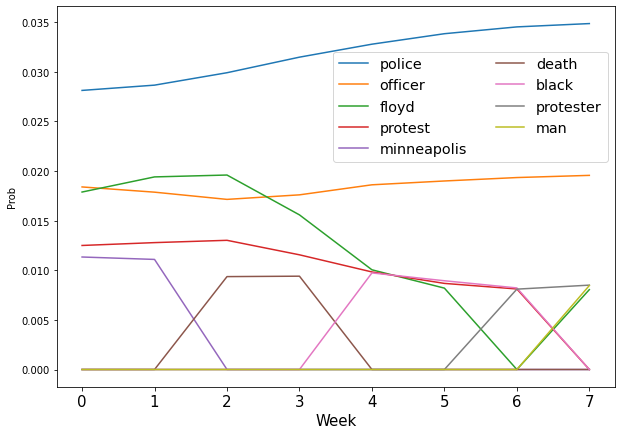

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(df_racism)
# ax.set_title('Keywords trend about racism', fontdict={'fontsize':14})
ax.set_xlabel('Week', fontdict={'fontsize':15})
ax.tick_params(axis='x',labelsize=15)
ax.set_ylabel('Prob')
ax.legend(df_racism.columns, loc='best', bbox_to_anchor=(1, 0.9), ncol=2,fontsize='x-large')

fig.savefig('racism.png')

In [ ]:
!cp racism.png /content/drive/My\ Drive/LDA_project/

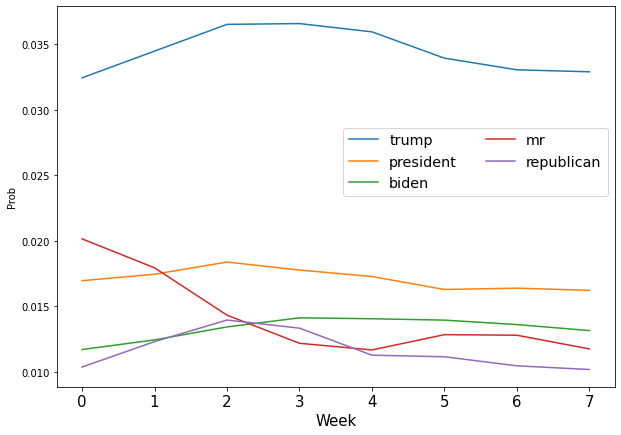

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(df_trump)
# ax.set_title('Keywords trend about racism', fontdict={'fontsize':14})
ax.set_xlabel('Week', fontdict={'fontsize':15})
ax.tick_params(axis='x',labelsize=15)
ax.set_ylabel('Prob')
ax.legend(df_trump.columns, loc='best', bbox_to_anchor=(1.0, 0.7), ncol=2,fontsize='x-large')

fig.savefig('trump.png')

In [ ]:
!cp trump.png /content/drive/My\ Drive/LDA_project/

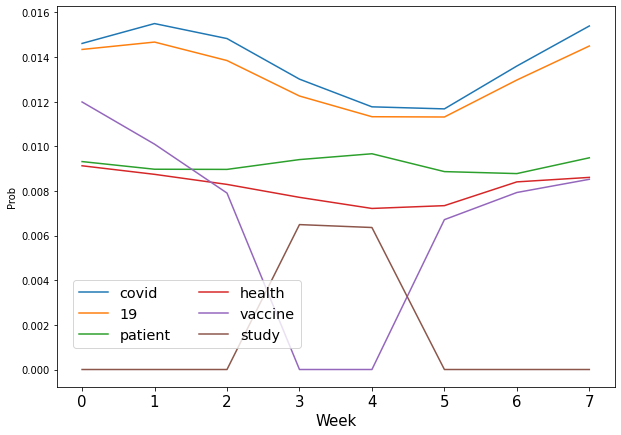

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(df_covid)
# ax.set_title('Keywords trend about racism', fontdict={'fontsize':14})
ax.set_xlabel('Week', fontdict={'fontsize':15})
ax.tick_params(axis='x',labelsize=15)
ax.set_ylabel('Prob')
ax.legend(df_covid.columns, loc='best', bbox_to_anchor=(0.45, 0.3), ncol=2,fontsize='x-large')

fig.savefig('covid.png')

In [ ]:
!cp covid.png /content/drive/My\ Drive/LDA_project/

In [ ]:
topics = sorted(lda.get_document_topics(corpus[0]), key=lambda t:t[1], reverse=True)
topics[0][0]

15

In [ ]:
a = 3
a in [1, 3, 2, 4]

True

In [ ]:
test = lda.get_document_topics(corpus[0])
# summ = 0
# for i, v in test:
#   summ += v
# summ
test

[(0, 0.012484941),
 (6, 0.0154380025),
 (7, 0.29822084),
 (13, 0.012641428),
 (14, 0.11279146),
 (15, 0.5102869),
 (18, 0.01859958)]

In [ ]:
samp = [0, 2, 4]
df_s_sample_s.iloc[samp]

id  ... numOfWeek
0  3015216788  ...        28
2  3009122756  ...        24
4  3007642134  ...        23

[3 rows x 10 columns]

In [ ]:
samp = [0, 2, 4]
df_s_sample.iloc[samp]

id  ...                    label
0  3015216788  ...        Special Education
2  3009122756  ...    Law, Gov’t & Politics
4  3007642134  ...  Panic/Anxiety Disorders

[3 rows x 6 columns]

In [ ]:
df_s_sample.body[7]

"Democratic U.S. presidential candidate and former U.S. Vice President Joe Biden visits a site of the protest over the death of George Floyd in Minneapolis police custody, in Wilmington, North Carolina, in this social media image courtesy of Joe Biden's presidential campaign, May 31, 2020. Courtesy of JOE BIDEN FOR PRESIDENT/Handout via REUTERS  \n\n\n(Reuters) - Democratic presidential candidate Joe Biden on Sunday toured the site of one of the protests that ripped through U.S. cities overnight and called for protesters against police brutality not to turn to violence. \nBiden, wearing a face mask, made his second appearance outside his Delaware home since the coronavirus crisis hit in March, visiting an area in Wilmington where demonstrators vented outrage at the death of a black man shown on video gasping for breath as a white Minneapolis policeman knelt on his neck. \nA campaign post on Instagram showed Biden speaking with African American residents and inspecting buildings boarded

In [ ]:
for t in topics[:10]:
    print("Topic # ",t[0])
    get_topic_words(t[0])
    print("\n")

Topic #  15
school: 0.0174808818846941
state: 0.01593627966940403
court: 0.013252614997327328
student: 0.011433420702815056
law: 0.009004565887153149
case: 0.008263876661658287
federal: 0.007292341440916061
justice: 0.006687917746603489
university: 0.006165537051856518
college: 0.005906801205128431


Topic #  7
black: 0.018879229202866554
facebook: 0.01151939295232296
twitter: 0.010851925238966942
people: 0.00926776323467493
post: 0.008440695703029633
social: 0.008064324967563152
medium: 0.007977209985256195
today: 0.006875781342387199
racism: 0.006298964377492666
white: 0.006074125878512859


Topic #  14
mr: 0.02745071053504944
people: 0.013694480061531067
m: 0.008634936064481735
time: 0.007691682316362858
american: 0.0065362416207790375
woman: 0.006013599224388599
life: 0.005927020683884621
work: 0.005274314898997545
york: 0.004740339703857899
black: 0.0042960066348314285


Topic #  18
player: 0.020161891356110573
team: 0.018763408064842224
season: 0.016248131170868874
game: 0.014911

In [ ]:
df_s_sample.body[0]

'LEVITTOWN, Pa. — T.R. Kannan is no stranger to racism.\n\nThe school board president in the Pennsbury School District in Bucks County, Pennsylvania, has seen it firsthand before immigrating to the U.S. from India, where discrimination on religion, caste and gender is widespread.\n\nMore than 20 years later, Kannan has grown accustomed to experiencing microaggressions, or unconscious biases that others may not be aware of.\n\n“Sometimes there’s a feeling of unease that’s always there,” he said. “I’ve seen it myself, I’ve heard it from family, friends and everyone.”\n\n\n\nTo create an environment in schools where students hopefully will not feel these pressures, the administration has asked the school board to come up with a plan to make equity a key focus by creating a dedicated position to provide “leadership and oversight in equity and excellence,” officials said.\n\n“You need to look at policies, you need to look at curriculum, you need to look at disciplinary practices, you need t

In [ ]:
N = sum(count for doc in test_corpus for id, count in doc)
bound = lda.bound(test_corpus) / N
perplexity = np.exp2(-bound)
perplexity = np.exp2(-lda.log_perplexity(test_corpus))
print("perplexity:", perplexity)

-8.879 per-word bound, 470.9 perplexity estimate based on a held-out corpus of 2135 documents with 592953 words


perplexity: 470.9464521655288


In [ ]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)

In [ ]:
doc_topics = np.array([lda[c] for c in corpus])

In [ ]:
doc_topics.shape

(21343, 20, 2)

In [ ]:
num_topics = 20

In [ ]:
features = np.zeros( (len(doc_topics), num_topics), float)

for doc_id, t in enumerate(doc_topics):
    for topic_id, weight in t:
        features[doc_id, int(topic_id)] = weight

In [ ]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(features, metric="cosine"))

In [ ]:
lda[corpus[1]]

[(0, 0.00015923566),
 (1, 0.00015923566),
 (2, 0.012889241),
 (3, 0.00015923566),
 (4, 0.00015923566),
 (5, 0.012936433),
 (6, 0.736157),
 (7, 0.2112906),
 (8, 0.00015923566),
 (9, 0.00015923566),
 (10, 0.00015923566),
 (11, 0.00015923566),
 (12, 0.00015923566),
 (13, 0.00015923566),
 (14, 0.00015923566),
 (15, 0.00015923566),
 (16, 0.024338244),
 (17, 0.00015923566),
 (18, 0.00015923566),
 (19, 0.00015923566)]

In [ ]:
def similar_to(doc_id, num=5, distance=False):
    doc = pairwise[doc_id]
    ids = np.argsort(doc)[1: num+1] # the most similar is self.
    if distance:
        dist = np.sort(doc)[1: num+1]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

In [ ]:
similar_to(0, num=10, distance=True)

[(3868, 0.030854603462609376),
 (4275, 0.03729734232214499),
 (9949, 0.042929010259323386),
 (13664, 0.045230415026875304),
 (20779, 0.05370500921662724),
 (7591, 0.06247388286509847),
 (12895, 0.06462831432022498),
 (12687, 0.0690149446859557),
 (3147, 0.07008203279485892),
 (8709, 0.07215192521423874)]

In [ ]:
from gensim import similarities

In [ ]:
doc_index = similarities.docsim.MatrixSimilarity(lda[corpus])

scanning corpus to determine the number of features (consider setting `num_features` explicitly)
creating matrix with 21343 documents and 20 features
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
doc_index.num_best

In [ ]:
c = corpus[7]
vec_lda = lda[c]
s = doc_index.__getitem__(vec_lda)

In [ ]:
s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)

In [ ]:
s[:30]

[(7, 1.0),
 (2523, 0.9990597),
 (9951, 0.99866295),
 (9464, 0.99830294),
 (12646, 0.9969628),
 (12827, 0.9964791),
 (16016, 0.9953772),
 (17788, 0.9952256),
 (9397, 0.9950914),
 (14967, 0.9945065),
 (7334, 0.9933607),
 (10987, 0.9931226),
 (15951, 0.9926603),
 (11951, 0.9926456),
 (14630, 0.9917548),
 (17490, 0.9915109),
 (9240, 0.99141777),
 (16264, 0.99126077),
 (13155, 0.9910867),
 (14521, 0.9907172),
 (10757, 0.9906614),
 (11664, 0.99065745),
 (15752, 0.9906226),
 (16680, 0.9900459),
 (7963, 0.98937786),
 (19869, 0.9880034),
 (20976, 0.9871793),
 (20486, 0.9867085),
 (7359, 0.98627037),
 (12300, 0.98566186)]

In [ ]:
df_s_sample.body[2523]

'(Reuters) - A conversation during which President Donald Trump urged U.S. state governors to crack down on nationwide protests became testy on Monday when Illinois governor J.B. Pritzker accused Trump of making the situation worse. \nTrump, who last week tweeted “when the looting starts, the shooting starts,” urged governors to get tough on disturbances following the death of George Floyd, an unarmed black man, in police custody in Minneapolis. A white officer has been charged. \nIn a recording of the conference call heard by Reuters, Trump said: “You have to dominate, if you don’t dominate you’re wasting your time. They’re going to run over you, you’re going to look like a bunch of jerks. You have to dominate.”  \nNear the end of the nearly hour-long call, Pritzker, a Democrat, challenged the Republican president.  \nHe called some of Trump’s public statements inflammatory and unhelpful to governors and mayors trying, not always with success, to keep peaceful protests from boiling ov

In [ ]:
# LDA Model
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha=’symmetric’, random_state=0)

# save model
lda_model.save('lda.model')

In [ ]:
# importing the dataset
test=pd.read_csv("../input/test_cleaned.csv")

# list
all_text = list(test['comment_text'])

# filter stopwords
test_texts = [[word for word in document.lower().split() if word not in stop_words] for document in all_text]

# make test_corpus
test_corpus = [dictionary.doc2bow(t) for t in test_texts]

# reduce memory
del test
del all_text
gc.collect()

# test
N = sum(count for doc in test_corpus for id, count in doc)
print("N: ",N)

perplexity = np.exp2(-lda_model.log_perplexity(test_corpus))
print("perplexity:", perplexity)

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 8.7MB/s 
     |████████████████████████████████| 552kB 42.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=03a7ff805726c77c347ba4fbc85cd5631bc580b6a07f281277682f950153677c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=3c93501dcace631793907b9ee2b0529eec157a84161ee4cd9cccbc8690fab001
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
import wordcloud
import pyLDAvis

In [ ]:
import math

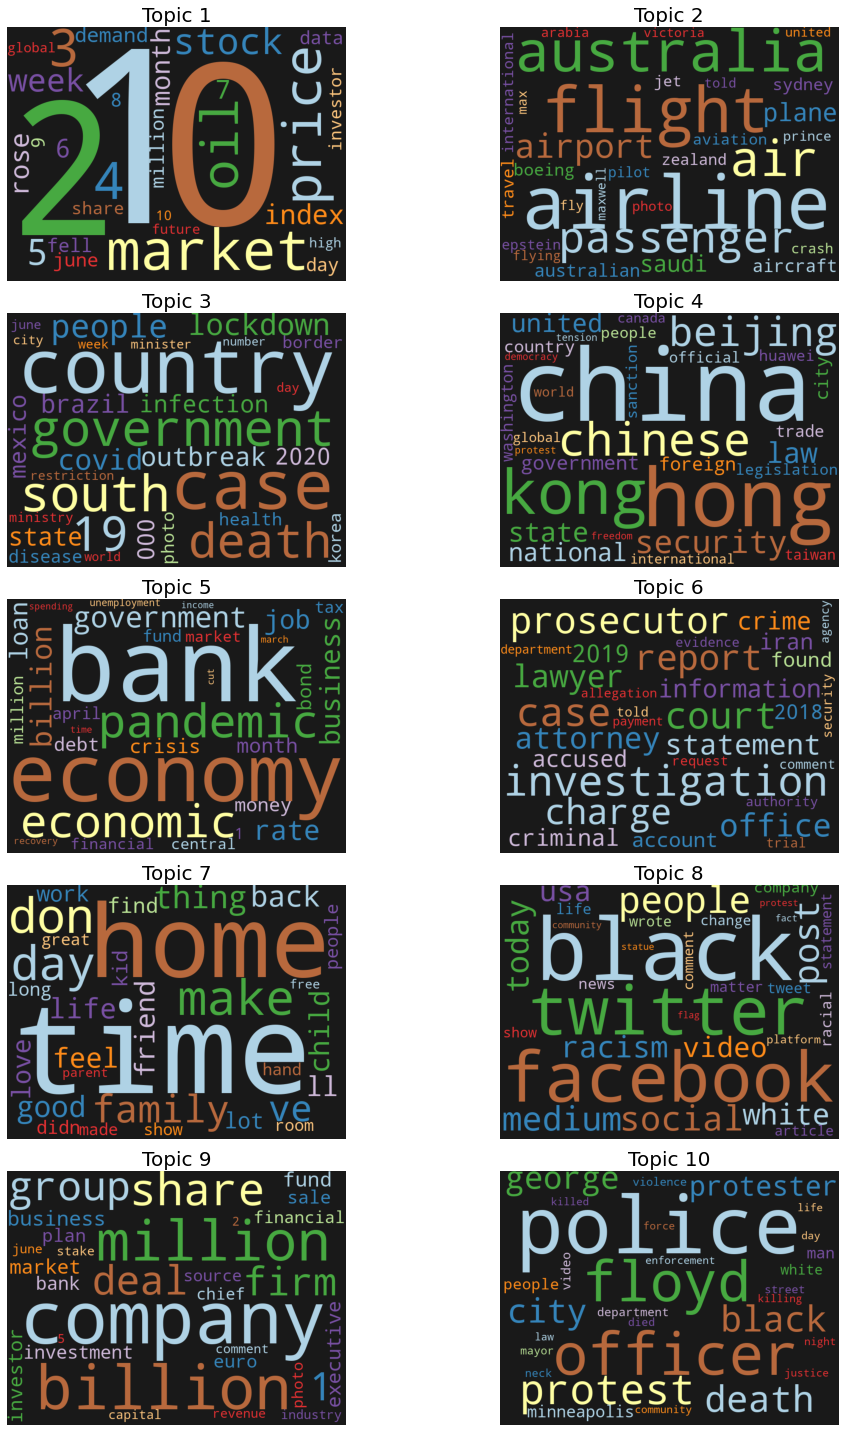

<Figure size 432x288 with 0 Axes>

In [ ]:
# WordCloud
fig, axs = plt.subplots(ncols=2, nrows=math.ceil(10/2), figsize=(16,20))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(10)):

    x = dict(lda.show_topic(t, 30))
    im = wordcloud.WordCloud(
        background_color='black',
        color_func=color_func,
        max_words=1000,
        width=800, height=600,
        random_state=42
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=15), alpha=0.90)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t+1), fontsize = 20)

# vis
plt.tight_layout()
plt.show()

# save as png
plt.savefig('/content/drive/My Drive/LDA_project/wordcloud1.png') 

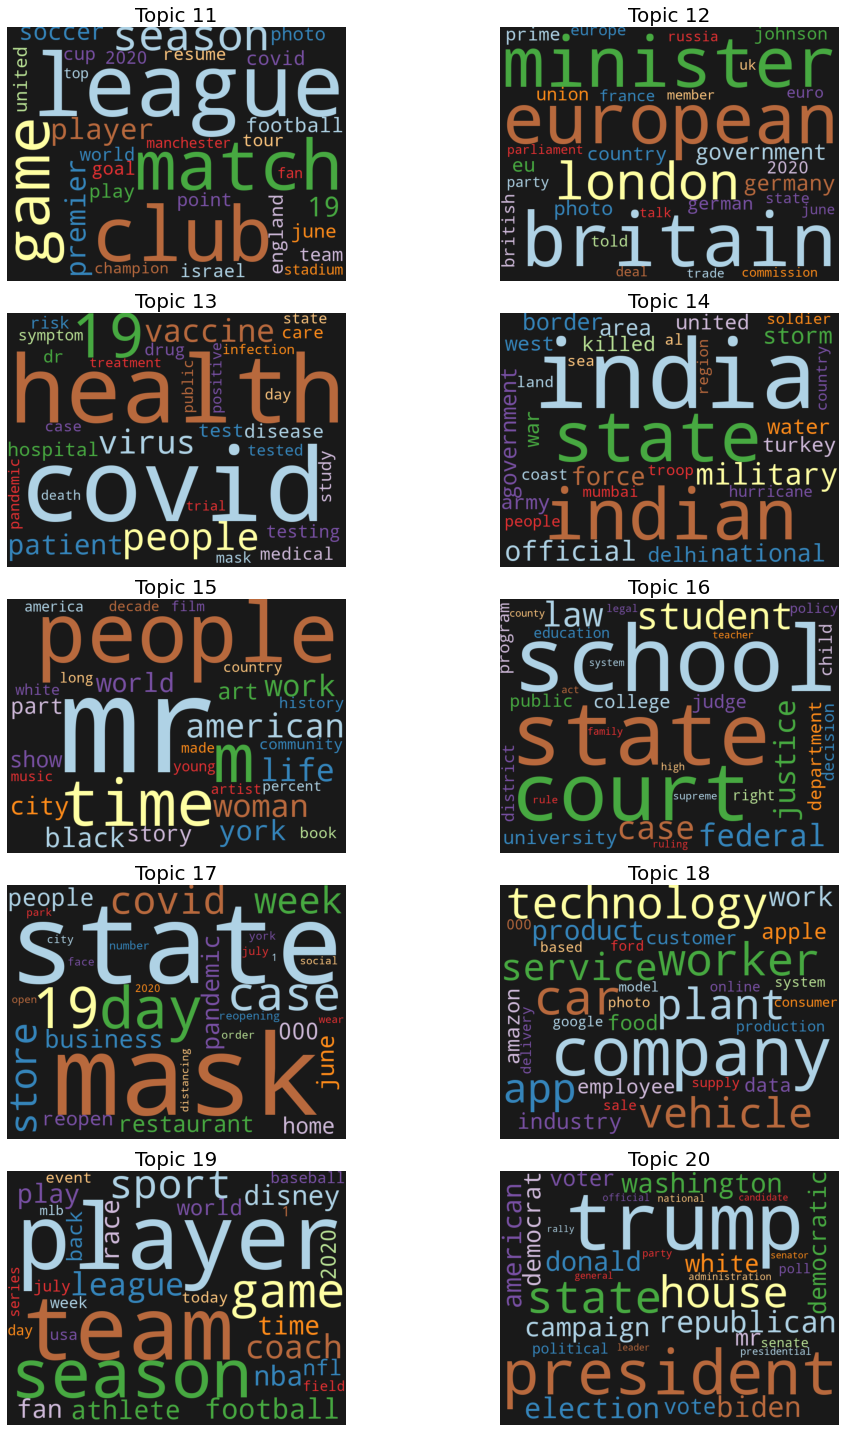

<Figure size 432x288 with 0 Axes>

In [ ]:
# WordCloud
fig, axs = plt.subplots(ncols=2, nrows=math.ceil(10/2), figsize=(16,20))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(10,20)):

    x = dict(lda.show_topic(t, 30))
    im = wordcloud.WordCloud(
        background_color='black',
        color_func=color_func,
        max_words=1000,
        width=800, height=600,
        random_state=42
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=15), alpha=0.90)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t+1), fontsize = 20)

# vis
plt.tight_layout()
plt.show()

# save as png
plt.savefig('/content/drive/My Drive/LDA_project/wordcloud2.png') 

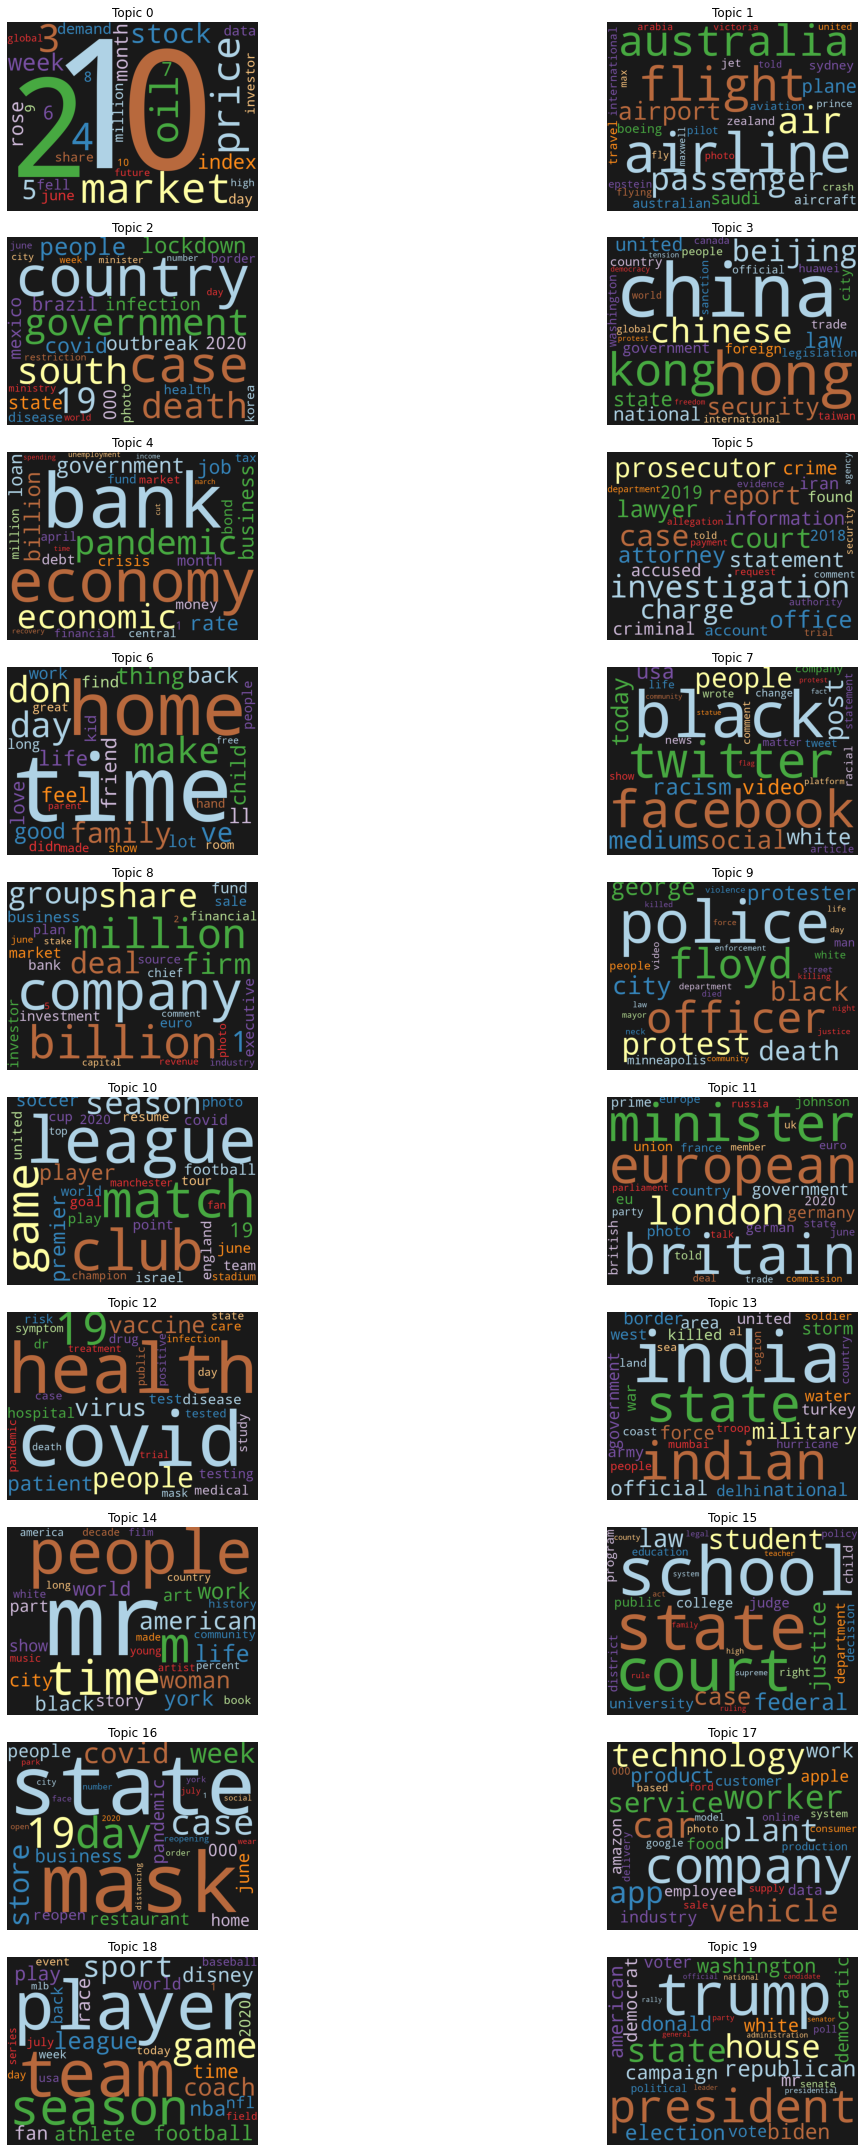

In [ ]:
# WordCloud
fig, axs = plt.subplots(ncols=2, nrows=math.ceil(lda.num_topics/2), figsize=(22,30))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda.num_topics)):

    x = dict(lda.show_topic(t, 30))
    im = wordcloud.WordCloud(
        background_color='black',
        color_func=color_func,
        max_words=4000,
        width=800, height=600,
        random_state=42
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=15), alpha=0.90)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t+1))

# vis
plt.tight_layout()
plt.show()

# save as png
# plt.savefig('wordcloud.png') 

In [ ]:
from pyLDAvis import gensim as gm

In [ ]:
# Vis PCoA
vis_pcoa = gm.prepare(lda, corpus, d, sort_topics=False)
vis_pcoa

# save as html
pyLDAvis.save_html(vis_pcoa, 'pyldavis_output_pcoa.html')

NumExpr defaulting to 4 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.247284  0.036520       1        1  7.411595
1      0.065561 -0.168017       2        1  1.185148
2      0.103606 -0.065457       3        1  4.144068
3     -0.032580 -0.173379       4        1  3.000771
4      0.170193  0.043090       5        1  6.020421
5     -0.104224 -0.150608       6        1  2.729937
6     -0.102926  0.214830       7        1  9.647471
7     -0.203337  0.036125       8        1  5.332977
8      0.166735 -0.009320       9        1  5.666003
9     -0.167300 -0.032261      10        1  5.552322
10     0.075100  0.107349      11        1  2.595491
11     0.045950 -0.120485      12        1  3.449778
12     0.005924  0.078934      13        1  6.452824
13     0.001259 -0.145028      14        1  2.086017
14    -0.197373  0.107090      15        1  7.884832
15    -0.121476 -0.024018      16        1  5.148373
16     0.098145

In [ ]:
pyLDAvis.display(vis_pcoa)

In [ ]:
# Vis t-SNE
vis_tsne = pyLDAvis.gensim.prepare(lda, corpus, d, mds='tsne', sort_topics=False)
pyLDAvis.display(vis_tsne)

# save as html
pyLDAvis.save_html(vis_tsne, 'pyldavis_output_tsne.html')

In [ ]:
!cp pyldavis_output_tsne.html /content/drive/My\ Drive/LDA_project/pyldavis_output_tsne.html

## Dynamic Topic modeling

In [ ]:
from urllib import request
import logging
from pathlib import Path
import random
import re

from gensim import corpora, models

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
try:
    if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
        print("tqdm is notebook version")
        from tqdm import tqdm_notebook as tqdm
    else:
        raise RuntimeError
except (NameError, RuntimeError):
    from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

In [ ]:
df_s_sample_w = pd.read_csv('/content/drive/My Drive/LDA_project/df_s_sample_s.csv',engine='python')
# df_s_sample_w.sort_values('date', inplace=True)
# df_s_sample_w.reset_index(inplace=True)
# df_s_sample_w.drop(columns='index', inplace=True)
# df_s_sample_w.head()

In [ ]:
df_s_sample_w = df_s_sample_w[(df_s_sample_w.numOfWeek > 20) & (df_s_sample_w.numOfWeek < 29)]
df_s_sample_w.head()

id  ... numOfWeek
204  3004258781  ...        21
205  3004259058  ...        21
206  3004259292  ...        21
207  3004259878  ...        21
208  3004260118  ...        21

[5 rows x 10 columns]

In [ ]:
df_s_sample_w.sentiment[204]

"{'body': {'polarity': 'negative', 'score': 0.973314},\n 'title': {'polarity': 'negative', 'score': 0.411991}}"

In [ ]:
summary = df_s_sample_w.groupby(['numOfWeek', 'source'], as_index=False).count()

In [ ]:
reuter = list(summary[summary.source == 'reuters.com'].body)
usatoday = list(summary[summary.source == 'usatoday.com'].body)
nytimes = list(summary[summary.source == 'nytimes.com'].body)

In [ ]:
x_ny = range(8)
x_us = list(map(lambda x: x + 0.2, x_ny))
x_re = list(map(lambda x: x + 0.2, x_us))

In [ ]:
x_us = range(8)
x_ny = list(map(lambda x: x - 0.3, x_us))
x_re = list(map(lambda x: x + 0.3, x_us))

2020/7/22

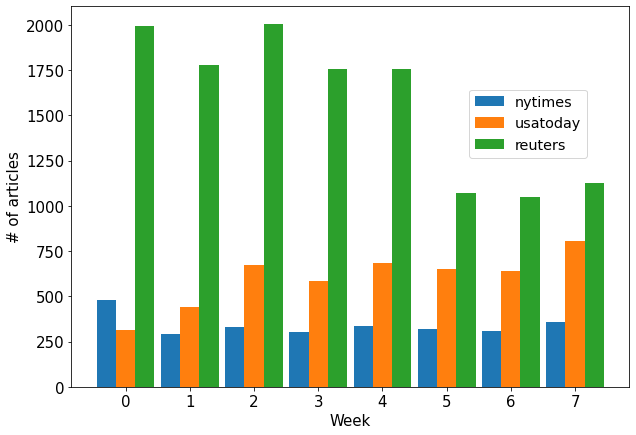

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

plt.bar(x_ny, nytimes, width=0.3, align='center')
plt.bar(x_us, usatoday, width=0.3, align='center')
plt.bar(x_re, reuter, width=0.3, align='center')

ax.set_xlabel('Week', fontdict={'fontsize':15})
# ax.set_xlim(,)
ax.tick_params(axis='both',labelsize=15)
ax.set_ylabel('# of articles', fontdict={'fontsize':15})
ax.legend(['nytimes','usatoday','reuters'], loc='best', 
          bbox_to_anchor=(0.7, 0.8), ncol=1, 
          fontsize='x-large')

plt.show()

fig.savefig('counts_articles.png')

In [ ]:
# count posi and nega

In [ ]:
df_s_sample_w.reset_index(inplace=True)
df_s_sample_w.drop(columns='index', inplace=True)
df_s_sample_w.head()

id  ... numOfWeek
0  3004258781  ...        21
1  3004259058  ...        21
2  3004259292  ...        21
3  3004259878  ...        21
4  3004260118  ...        21

[5 rows x 10 columns]

In [ ]:
df_s_sample_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20058 non-null  int64 
 1   title      20058 non-null  object
 2   date       20058 non-null  object
 3   body       20058 non-null  object
 4   source     20058 non-null  object
 5   keywords   20058 non-null  object
 6   label      19970 non-null  object
 7   sentiment  20058 non-null  object
 8   summary    20044 non-null  object
 9   numOfWeek  20058 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 1.5+ MB
